 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D-09   r2 =  0.4007848759606D-37
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D-09   r2 =  0.4007848759606D-37
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D-09   r2 =  0.4007848759606D-33
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D-09   r2 =  0.4007848759606D-33
 lsoda--  warning..internal t (=r1) 

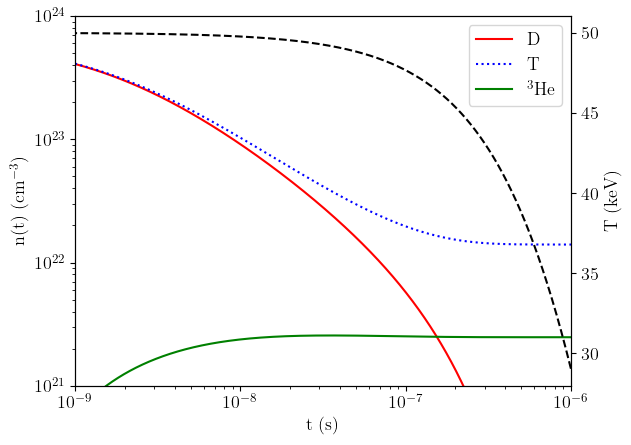

0.6143569946289062 sec


In [58]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotx
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 13})
rc('text', usetex=True)
import time

####reactivity parametrization of DT, D3He, DDp, DDn reactions
def react(T,  channel):
    if channel == 'dt':
        Bg  = 34.3827;     mc2 = 1124656;     C1  = 1.17302e-9;  C2  = 1.51361e-2;
        C3  = 7.51886e-2;  C4  = 4.60643e-3;  C5  = 1.35e-2;     C6  = -1.0675e-4;
        C7  = 1.366e-5
    if channel == 'd3he':
        Bg  = 68.7508;     mc2 = 1124572;     C1  = 5.51036e-10; C2  = 6.41918e-3
        C3  = -2.02896e-3; C4  = -1.91080e-5; C5  = 1.35776e-4;  C6  = C7 = 0
    if channel == 'ddp':
        Bg  = 31.397;      mc2 = 937814;      C1  = 5.65718e-12; C2  = 3.41267e-3;
        C3  = 1.99167e-3;  C4  = C6 = C7 = 0; C5  = 1.0506e-5;
    if channel == 'ddn':
        Bg  = 31.397;      mc2 = 937814;      C1  = 5.4336e-12;  C2  = 5.85778e-3;
        C3  = 7.68222e-3;  C4  = C6 = C7 = 0; C5  = -2.964e-6;
        
    teta = T / ( 1 - T*(C2+T*(C4+T*C6))/(1 +T*(C3+T*(C5+T*C7))) )
    ksi = (Bg**2 / teta/4)**(1/3)
    reactivity = C1*teta*np.sqrt(ksi/(mc2*T**3))*np.exp(-3*ksi) 
    return reactivity
###################################################################

start = time.time()

def F(s,t_int):

    r_dd_p = react(s[3],'ddp') 
    r_dd_n = react(s[3],'ddn') 
    r_dt =   react(s[3],'dt')
    r_d3he = react(s[3],'d3he')    
    r_dd =   react(s[3],'ddp') + react(s[3],'ddn')
    
    Q_ddp = 4.03; Q_ddn = 3.27; Q_d3he = 18.35
    E_ddn = 0.82; E_adt = 3.52; E_n1 = 2.45;   E_n2 = 14.07
    
    nd   = -1.0*r_dd   * s[0]*s[0]  -r_dt*s[0]*s[1] -r_d3he*s[0]*s[2]
    
    nt   = +0.5*r_dd_p * s[0]*s[0] -r_dt*s[0]*s[1] 
    
    n3he = +0.5*r_dd_n * s[0]*s[0] -r_d3he*s[0]*s[2]    
    
    Ech =  (0.5*r_dd_p * s[0]*s[0]* Q_ddp + r_dt  * s[0]*s[1]* E_adt+
            0.5*r_dd_n * s[0]*s[0]* E_ddn + r_d3he* s[0]*s[2]* Q_d3he)
    
    En =    0.5*r_dd_n * s[0]*s[0]* E_n1 +  r_dt  * s[0]*s[1]* E_n2
    
    T = (Ech-0.334*1e-17*np.sqrt(s[3])*(nd+nt+4*n3he)*1e+24)/(nd+nt+n3he)
    
    return [nd, nt, n3he, T, Ech, En]

t_int = np.linspace(0.5e-9,1e-6, 100000)
#initial concentrations n_d,n_t,n_3he and energies Ech, En
n0=[5e+23,5e+23,0,50, 0, 0] 
sol = odeint(F,n0,t_int)

fig, ax1 = plt.subplots()
ax1.plot(t_int,sol[:,0],'r-', linewidth=1.5)
ax1.plot(t_int,sol[:,1],'b:', linewidth=1.5)
ax1.plot(t_int,sol[:,2],'g-', linewidth=1.5)
ax1.set(ylim=[1e+21, 1e+24], yscale ='log')
ax1.set(xlim=[1e-9,1e-6], xscale = 'log')
ax1.set_ylabel('n(t) (cm$^{-3}$)')
plt.xlabel('t (s)')
plt.legend(['D', 'T', '$^{3}$He'])
ax2 = ax1.twinx()


ax2.plot(t_int,sol[:,3],'k--', linewidth=1.5)
ax2.set(ylabel = 'T (keV)')

###ax2 for energy densities Ech and En
#ax2.set(ylim = [1e+20, 1e+25], yscale = 'log')
#ax2.plot(t_int,sol[:,4],'k--', linewidth=1.5)
#ax2.plot(t_int,sol[:,5],'y--', linewidth=1.5)
#ax2.set_ylabel('$E_{ch}$, $E_{n}$, $MeV/cm^{3}$', loc = 'center')

###labels for lines 
#ax1.text(1.2e-8, 5.4e+23,'$T_{i}$ = '+str(T)+' keV')
#ax1.text(3e-7, 5.2e+23,'$^{3}He$')
#ax1.text(6e-8, 4.4e+23,'$D$')
#ax1.text(6e-8, 0.7e+23,'$T\cdot 10^{2}$')
#ax1.text(1e-8, 3.1e+23,'$E_{ch}$')
#ax1.text(3e-8, 2.4e+23,'$E_{n}$')
#plt.savefig('DTfuel_burn.jpg', dpi= 1000,bbox_inches='tight')
plt.show()
end = time.time() - start
print(end,'sec')

In [54]:
sol[:,3]

array([50.        , 49.99976625, 49.99953249, ..., 29.03397464,
       29.03379386, 29.03361308])